# 02_baseline_models.ipynb - Comprehensive Baseline Model Evaluation

This notebook provides a systematic comparison of baseline machine learning models for house price prediction. We'll evaluate multiple algorithms using consistent metrics to establish performance benchmarks before moving to advanced methods.

## Models Evaluated:
1. **Linear Regression** - Basic linear relationship baseline
2. **Ridge Regression** - L2 regularized linear model 
3. **Random Forest** - Tree-based ensemble method
4. **Gradient Boosting** - Sequential boosting approach
5. **Support Vector Regression** - Kernel-based regression
6. **K-Nearest Neighbors** - Instance-based learning

## Evaluation Metrics:
- **R² Score** (Primary): Coefficient of determination 
- **RMSE**: Root Mean Square Error in dollars
- **MAPE**: Mean Absolute Percentage Error
- **MAE**: Mean Absolute Error in dollars

**Input:** `data/cleaned_enhanced.csv` (from enhanced preprocessing)
**Target:** ClosePrice prediction with comprehensive baseline comparison

In [1]:
# Section 1: Imports and Setup
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Model imports
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import joblib
import json
from datetime import datetime

# Plotting setup
plt.style.use('default')
sns.set_palette("husl")

print("Baseline Models Evaluation - Setup Complete")
print(f"Analysis timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Baseline Models Evaluation - Setup Complete
Analysis timestamp: 2025-10-06 00:22:42


In [2]:
# Section 2: Data Loading and Preparation
ROOT = Path(r"c:\\Users\\lpnhu\\Downloads\\home-price-prediction")
DATA_DIR = ROOT / 'data'
ENHANCED_PATH = DATA_DIR / 'cleaned_enhanced.csv'
MODELS_DIR = ROOT / 'models'
MODELS_DIR.mkdir(exist_ok=True)

print('=== LOADING ENHANCED DATASET ===')

# Load the enhanced dataset
if not ENHANCED_PATH.exists():
    print(f'Enhanced dataset not found at {ENHANCED_PATH}')
    print('Please run the 01_cleaning.ipynb notebook first to create the enhanced dataset.')
    raise FileNotFoundError(f'Enhanced dataset not found: {ENHANCED_PATH}')

data = pd.read_csv(ENHANCED_PATH)
print(f'Loaded enhanced dataset: {data.shape}')
print(f'Features available: {len(data.columns)} columns')
print(f'Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

# Prepare features and target
exclude_columns = ['ClosePrice', 'ListingId', 'UnparsedAddress']
feature_columns = [col for col in data.columns if col not in exclude_columns]

X = data[feature_columns].copy()
y = data['ClosePrice'].copy()

# Handle any remaining missing values
missing_before = X.isnull().sum().sum()
if missing_before > 0:
    print(f'Imputing {missing_before} missing values with median...')
    X = X.fillna(X.median())

print(f'\n=== DATASET SUMMARY ===')
print(f'Feature matrix: {X.shape}')
print(f'Target variable: {y.shape}')
print(f'Target range: ${y.min():,.0f} - ${y.max():,.0f}')
print(f'Target mean: ${y.mean():,.0f}')
print(f'Target median: ${y.median():,.0f}')

=== LOADING ENHANCED DATASET ===
Loaded enhanced dataset: (72611, 454)
Features available: 454 columns
Memory usage: 50.70 MB
Imputing 20918 missing values with median...
Loaded enhanced dataset: (72611, 454)
Features available: 454 columns
Memory usage: 50.70 MB
Imputing 20918 missing values with median...

=== DATASET SUMMARY ===
Feature matrix: (72611, 451)
Target variable: (72611,)
Target range: $0 - $2,680,000
Target mean: $1,001,183
Target median: $855,000

=== DATASET SUMMARY ===
Feature matrix: (72611, 451)
Target variable: (72611,)
Target range: $0 - $2,680,000
Target mean: $1,001,183
Target median: $855,000


In [3]:
# Section 3: Train/Test Split and Scaling Setup
print('=== DATA SPLITTING AND SCALING ===')

# Create consistent train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f'Training set: {X_train.shape[0]:,} samples')
print(f'Test set: {X_test.shape[0]:,} samples')

# Prepare scalers for models that need normalized features
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Fit scalers on training data only
X_train_std = standard_scaler.fit_transform(X_train)
X_test_std = standard_scaler.transform(X_test)

X_train_minmax = minmax_scaler.fit_transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

print(f'Scaling complete - StandardScaler and MinMaxScaler fitted')

=== DATA SPLITTING AND SCALING ===
Training set: 58,088 samples
Test set: 14,523 samples
Scaling complete - StandardScaler and MinMaxScaler fitted
Scaling complete - StandardScaler and MinMaxScaler fitted


In [4]:
# Section 4: Evaluation Framework
def evaluate_model(model, X_train_data, X_test_data, y_train, y_test, model_name, scaling_type="None"):
    """
    Comprehensive model evaluation with consistent metrics
    """
    print(f'\n=== {model_name} ===')
    
    # Train the model
    start_time = datetime.now()
    model.fit(X_train_data, y_train)
    training_time = (datetime.now() - start_time).total_seconds()
    
    # Make predictions
    y_pred_train = model.predict(X_train_data)
    y_pred_test = model.predict(X_test_data)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
    
    # Cross-validation R² score
    cv_scores = cross_val_score(model, X_train_data, y_train, cv=5, scoring='r2', n_jobs=-1)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Results dictionary
    results = {
        'model_name': model_name,
        'scaling': scaling_type,
        'training_time': training_time,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_r2_mean': cv_mean,
        'cv_r2_std': cv_std,
        'rmse': test_rmse,
        'mae': test_mae,
        'mape': test_mape,
        'model_object': model
    }
    
    # Print results
    print(f'  Scaling: {scaling_type}')
    print(f'  Training time: {training_time:.2f}s')
    print(f'  R² (train): {train_r2:.4f}')
    print(f'  R² (test):  {test_r2:.4f}')
    print(f'  R² (CV):    {cv_mean:.4f} ± {cv_std:.4f}')
    print(f'  RMSE:       ${test_rmse:,.0f}')
    print(f'  MAE:        ${test_mae:,.0f}')
    print(f'  MAPE:       {test_mape*100:.2f}%')
    
    # Check for overfitting
    overfitting = train_r2 - test_r2
    if overfitting > 0.1:
        print(f'  ⚠ Potential overfitting: {overfitting:.3f} difference')
    
    return results

# Initialize results storage
baseline_results = []

In [5]:
# Section 5: Baseline Model Evaluation

print('=== BASELINE MODELS EVALUATION ===')

# 1. Linear Regression
lr = LinearRegression()
lr_results = evaluate_model(lr, X_train, X_test, y_train, y_test, "Linear Regression")
baseline_results.append(lr_results)

# 2. Ridge Regression (with scaling)
ridge = Ridge(alpha=1.0, random_state=42)
ridge_results = evaluate_model(ridge, X_train_std, X_test_std, y_train, y_test, 
                              "Ridge Regression", "StandardScaler")
baseline_results.append(ridge_results)

# 3. Lasso Regression (with scaling)
lasso = Lasso(alpha=1.0, random_state=42, max_iter=2000)
lasso_results = evaluate_model(lasso, X_train_std, X_test_std, y_train, y_test,
                              "Lasso Regression", "StandardScaler") 
baseline_results.append(lasso_results)

# 4. Elastic Net (with scaling)
elastic = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42, max_iter=2000)
elastic_results = evaluate_model(elastic, X_train_std, X_test_std, y_train, y_test,
                                "Elastic Net", "StandardScaler")
baseline_results.append(elastic_results)

# 5. Decision Tree
dt = DecisionTreeRegressor(max_depth=10, min_samples_split=20, min_samples_leaf=10, random_state=42)
dt_results = evaluate_model(dt, X_train, X_test, y_train, y_test, "Decision Tree")
baseline_results.append(dt_results)

# 6. Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=10, 
                          min_samples_leaf=5, random_state=42, n_jobs=-1)
rf_results = evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")
baseline_results.append(rf_results)

=== BASELINE MODELS EVALUATION ===

=== Linear Regression ===
  Scaling: None
  Training time: 2.24s
  R² (train): 0.8117
  R² (test):  0.8129
  R² (CV):    0.8074 ± 0.0045
  RMSE:       $233,379
  MAE:        $165,155
  MAPE:       19.54%

=== Ridge Regression ===
  Scaling: None
  Training time: 2.24s
  R² (train): 0.8117
  R² (test):  0.8129
  R² (CV):    0.8074 ± 0.0045
  RMSE:       $233,379
  MAE:        $165,155
  MAPE:       19.54%

=== Ridge Regression ===
  Scaling: StandardScaler
  Training time: 0.48s
  R² (train): 0.8117
  R² (test):  0.8129
  R² (CV):    nan ± nan
  RMSE:       $233,379
  MAE:        $165,155
  MAPE:       19.54%

=== Lasso Regression ===
  Scaling: StandardScaler
  Training time: 0.48s
  R² (train): 0.8117
  R² (test):  0.8129
  R² (CV):    nan ± nan
  RMSE:       $233,379
  MAE:        $165,155
  MAPE:       19.54%

=== Lasso Regression ===
  Scaling: StandardScaler
  Training time: 274.52s
  R² (train): 0.8117
  R² (test):  0.8129
  R² (CV):    nan ± n

In [6]:
# Section 6: Tree-Based and Instance-Based Models

# 7. Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, 
                              min_samples_split=20, min_samples_leaf=10, 
                              subsample=0.8, random_state=42)
gb_results = evaluate_model(gb, X_train, X_test, y_train, y_test, "Gradient Boosting")
baseline_results.append(gb_results)

# 8. Support Vector Regression (with scaling - smaller sample for speed)
print(f'\nNote: Using subset for SVR due to computational complexity...')
n_svr_samples = min(10000, len(X_train))
X_train_svr = X_train_std[:n_svr_samples]
y_train_svr = y_train.iloc[:n_svr_samples]

svr = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
svr_results = evaluate_model(svr, X_train_svr, X_test_std, y_train_svr, y_test,
                            "Support Vector Regression", "StandardScaler")
baseline_results.append(svr_results)

# 9. K-Nearest Neighbors (with scaling)
knn = KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=-1)
knn_results = evaluate_model(knn, X_train_minmax, X_test_minmax, y_train, y_test,
                            "K-Nearest Neighbors", "MinMaxScaler")
baseline_results.append(knn_results)

print(f'\nBaseline evaluation complete! {len(baseline_results)} models evaluated.')


=== Gradient Boosting ===
  Scaling: None
  Training time: 85.45s
  R² (train): 0.9006
  R² (test):  0.8838
  R² (CV):    0.8826 ± 0.0018
  RMSE:       $183,867
  MAE:        $120,256
  MAPE:       13.36%

Note: Using subset for SVR due to computational complexity...

=== Support Vector Regression ===
  Scaling: None
  Training time: 85.45s
  R² (train): 0.9006
  R² (test):  0.8838
  R² (CV):    0.8826 ± 0.0018
  RMSE:       $183,867
  MAE:        $120,256
  MAPE:       13.36%

Note: Using subset for SVR due to computational complexity...

=== Support Vector Regression ===
  Scaling: StandardScaler
  Training time: 30.86s
  R² (train): -0.0568
  R² (test):  -0.0608
  R² (CV):    -0.0614 ± 0.0092
  RMSE:       $555,652
  MAE:        $405,875
  MAPE:       47.76%

=== K-Nearest Neighbors ===
  Scaling: StandardScaler
  Training time: 30.86s
  R² (train): -0.0568
  R² (test):  -0.0608
  R² (CV):    -0.0614 ± 0.0092
  RMSE:       $555,652
  MAE:        $405,875
  MAPE:       47.76%

=== K

In [7]:
# Section 7: Results Summary and Comparison

print('=== BASELINE RESULTS SUMMARY ===')

# Create results DataFrame
results_df = pd.DataFrame([
    {
        'Model': result['model_name'],
        'Scaling': result['scaling'],
        'R² (Test)': result['test_r2'],
        'R² (CV)': result['cv_r2_mean'],
        'CV Std': result['cv_r2_std'],
        'RMSE ($)': result['rmse'],
        'MAE ($)': result['mae'],
        'MAPE (%)': result['mape'] * 100,
        'Training Time (s)': result['training_time']
    }
    for result in baseline_results
])

# Sort by test R² score
results_df = results_df.sort_values('R² (Test)', ascending=False).reset_index(drop=True)

print("\nModel Performance Ranking:")
print(results_df.round(4).to_string(index=False))

# Identify best performing model
best_model = results_df.iloc[0]
print(f'\nBest Baseline Model: {best_model["Model"]}')
print(f'  R² Score: {best_model["R² (Test)"]:.4f}')
print(f'  RMSE: ${best_model["RMSE ($)"]:,.0f}')
print(f'  MAPE: {best_model["MAPE (%)"]:.2f}%')

=== BASELINE RESULTS SUMMARY ===

Model Performance Ranking:
                    Model        Scaling  R² (Test)  R² (CV)  CV Std    RMSE ($)     MAE ($)  MAPE (%)  Training Time (s)
            Random Forest           None     0.8842   0.8817  0.0022 183614.2939 117213.4136   12.9279            31.9355
        Gradient Boosting           None     0.8838   0.8826  0.0018 183866.6297 120256.2993   13.3599            85.4523
            Decision Tree           None     0.8428   0.8368  0.0042 213887.9576 140756.6919   15.4088             1.7628
         Lasso Regression StandardScaler     0.8129      NaN     NaN 233377.9772 165153.6143   19.5445           274.5235
         Ridge Regression StandardScaler     0.8129      NaN     NaN 233379.2828 165154.8039   19.5446             0.4808
        Linear Regression           None     0.8129   0.8074  0.0045 233379.4700 165155.3736   19.5448             2.2440
      K-Nearest Neighbors   MinMaxScaler     0.7898   0.7848  0.0030 247369.2410 1580

=== CREATING PERFORMANCE VISUALIZATIONS ===


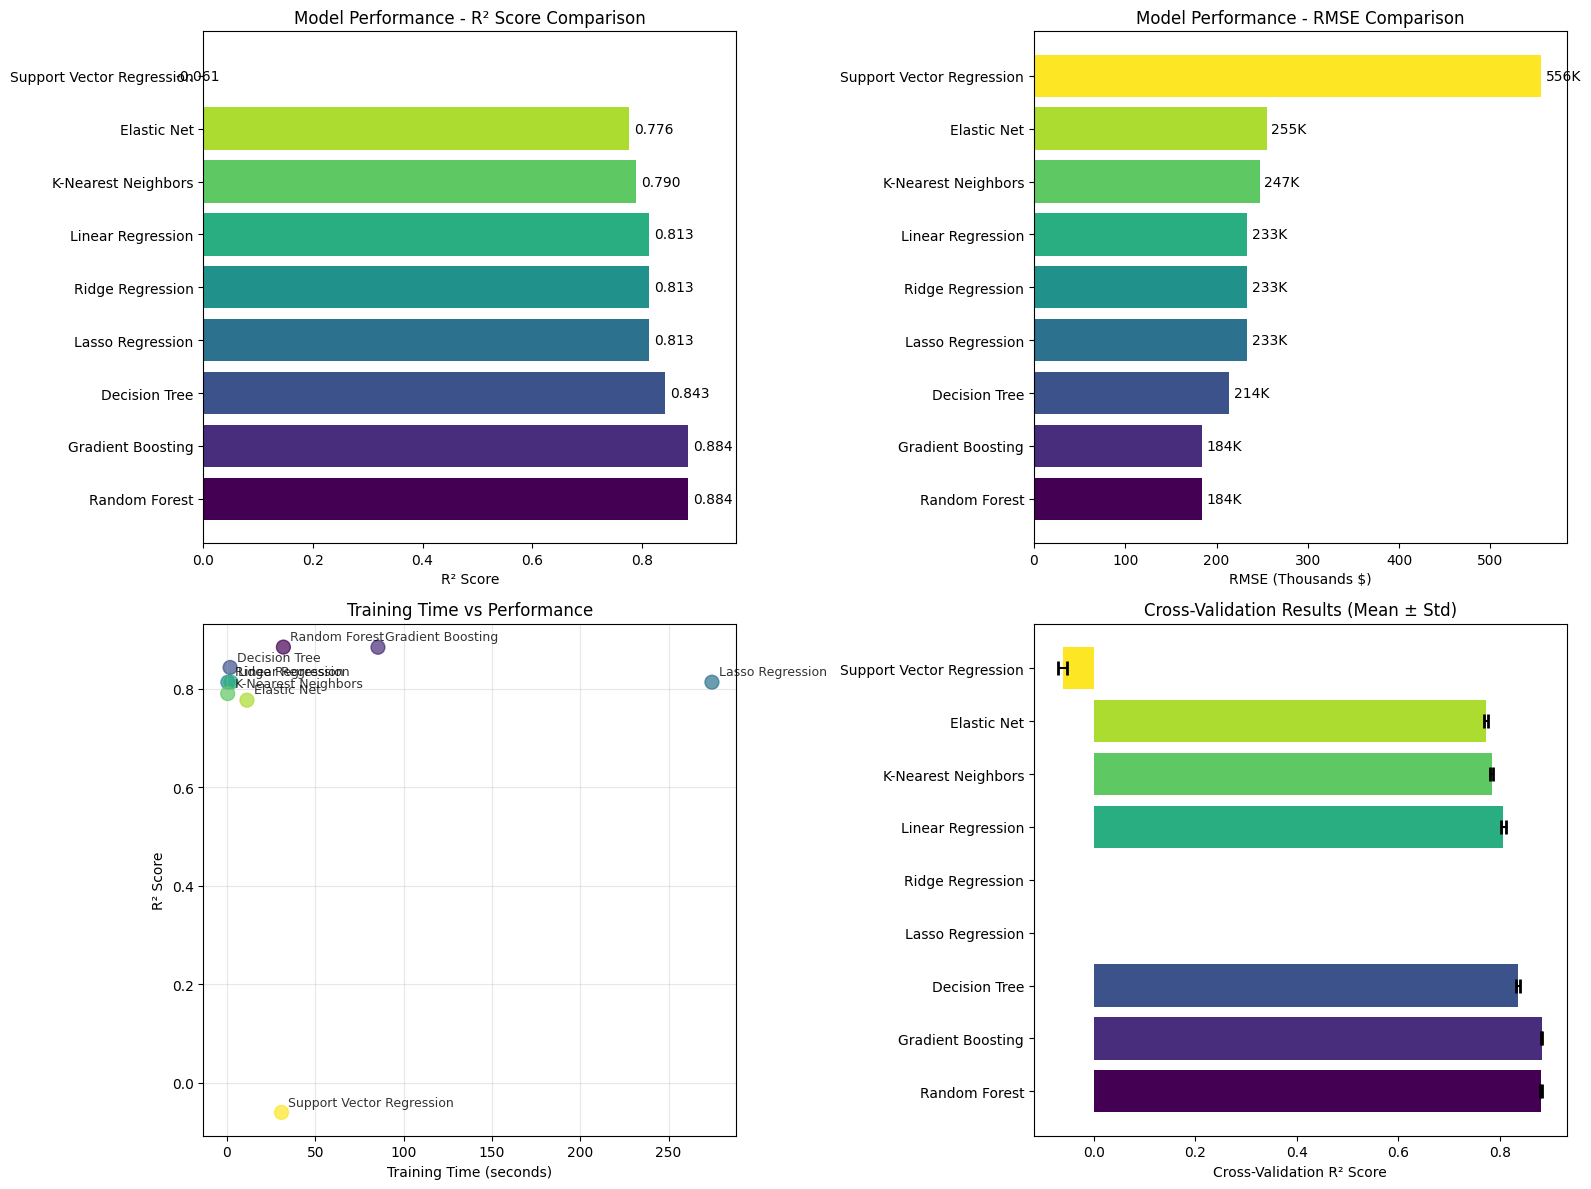

Comparison plot saved to: c:\Users\lpnhu\Downloads\home-price-prediction\models\baseline_models_comparison.png


<Figure size 640x480 with 0 Axes>

In [8]:
# Section 8: Visualization and Analysis

print('=== CREATING PERFORMANCE VISUALIZATIONS ===')

# Set up the plotting area
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R² Score Comparison
ax1 = axes[0, 0]
models = results_df['Model']
r2_scores = results_df['R² (Test)']
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

bars1 = ax1.barh(models, r2_scores, color=colors)
ax1.set_xlabel('R² Score')
ax1.set_title('Model Performance - R² Score Comparison')
ax1.set_xlim(0, max(r2_scores) * 1.1)

# Add value labels on bars
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=10)

# 2. RMSE Comparison
ax2 = axes[0, 1]
rmse_scores = results_df['RMSE ($)'] / 1000  # Convert to thousands
bars2 = ax2.barh(models, rmse_scores, color=colors)
ax2.set_xlabel('RMSE (Thousands $)')
ax2.set_title('Model Performance - RMSE Comparison')

# Add value labels
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + 5, bar.get_y() + bar.get_height()/2, 
             f'{width:.0f}K', ha='left', va='center', fontsize=10)

# 3. Training Time vs Performance
ax3 = axes[1, 0]
training_times = results_df['Training Time (s)']
scatter = ax3.scatter(training_times, r2_scores, c=range(len(models)), 
                     s=100, cmap='viridis', alpha=0.7)

# Add model name annotations
for i, model in enumerate(models):
    ax3.annotate(model, (training_times.iloc[i], r2_scores.iloc[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9, alpha=0.8)

ax3.set_xlabel('Training Time (seconds)')
ax3.set_ylabel('R² Score')
ax3.set_title('Training Time vs Performance')
ax3.grid(True, alpha=0.3)

# 4. Cross-Validation Results
ax4 = axes[1, 1]
cv_means = results_df['R² (CV)']
cv_stds = results_df['CV Std']

bars4 = ax4.barh(models, cv_means, xerr=cv_stds, color=colors, 
                capsize=5, error_kw={'capthick': 2})
ax4.set_xlabel('Cross-Validation R² Score')
ax4.set_title('Cross-Validation Results (Mean ± Std)')

plt.tight_layout()
plt.show()

# Save the visualization
plot_path = MODELS_DIR / 'baseline_models_comparison.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f'Comparison plot saved to: {plot_path}')

In [9]:
# Section 9: Save Results and Best Model

print('=== SAVING RESULTS AND BEST MODEL ===')

# Save detailed results
baseline_summary = {
    'evaluation_timestamp': datetime.now().isoformat(),
    'dataset_info': {
        'total_samples': len(data),
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'features_count': len(feature_columns),
        'target_variable': 'ClosePrice'
    },
    'models_evaluated': len(baseline_results),
    'best_model': {
        'name': best_model['Model'],
        'r2_score': float(best_model['R² (Test)']),
        'rmse': float(best_model['RMSE ($)']),
        'mae': float(best_model['MAE ($)']),
        'mape': float(best_model['MAPE (%)']) / 100,
        'training_time': float(best_model['Training Time (s)'])
    },
    'all_results': [
        {
            'model_name': result['model_name'],
            'scaling': result['scaling'],
            'test_r2': float(result['test_r2']),
            'cv_r2_mean': float(result['cv_r2_mean']),
            'cv_r2_std': float(result['cv_r2_std']),
            'rmse': float(result['rmse']),
            'mae': float(result['mae']),
            'mape': float(result['mape']),
            'training_time': float(result['training_time'])
        }
        for result in baseline_results
    ]
}

# Save summary
summary_path = MODELS_DIR / 'baseline_models_summary.json'
with open(summary_path, 'w') as f:
    json.dump(baseline_summary, f, indent=2)

# Save the best model
best_model_obj = next(result['model_object'] for result in baseline_results 
                     if result['model_name'] == best_model['Model'])

best_model_path = MODELS_DIR / f'best_baseline_{best_model["Model"].lower().replace(" ", "_")}.joblib'
joblib.dump(best_model_obj, best_model_path)

# Save results DataFrame
results_csv_path = MODELS_DIR / 'baseline_models_results.csv'
results_df.to_csv(results_csv_path, index=False)

print(f'Summary saved to: {summary_path}')
print(f'Best model saved to: {best_model_path}')
print(f'Results table saved to: {results_csv_path}')

print(f'\n=== BASELINE EVALUATION COMPLETE ===')
print(f'Best performing model: {best_model["Model"]}')
print(f'Achieved R² = {best_model["R² (Test)"]:.4f}')
print(f'Target for advanced methods: > {best_model["R² (Test)"]:.4f}')

=== SAVING RESULTS AND BEST MODEL ===
Summary saved to: c:\Users\lpnhu\Downloads\home-price-prediction\models\baseline_models_summary.json
Best model saved to: c:\Users\lpnhu\Downloads\home-price-prediction\models\best_baseline_random_forest.joblib
Results table saved to: c:\Users\lpnhu\Downloads\home-price-prediction\models\baseline_models_results.csv

=== BASELINE EVALUATION COMPLETE ===
Best performing model: Random Forest
Achieved R² = 0.8842
Target for advanced methods: > 0.8842
Summary saved to: c:\Users\lpnhu\Downloads\home-price-prediction\models\baseline_models_summary.json
Best model saved to: c:\Users\lpnhu\Downloads\home-price-prediction\models\best_baseline_random_forest.joblib
Results table saved to: c:\Users\lpnhu\Downloads\home-price-prediction\models\baseline_models_results.csv

=== BASELINE EVALUATION COMPLETE ===
Best performing model: Random Forest
Achieved R² = 0.8842
Target for advanced methods: > 0.8842
